# Sequitur and graph metrics for speech

### metrics
- number of nodes
- number of edges
- predictability / entropy of adjacency matrix
- sequitur
- In general, a network is considered “complex” if it exhibits many features such as small diameter, high clustering coefficient, anticorrelation of node degrees, presence of network motifs, and modularity structures [8].
    - - https://www.hindawi.com/journals/complexity/2017/3250301/

In [1]:
%load_ext autoreload
%autoreload 2

In [250]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

In [8]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


In [9]:
import seaborn as sns
from childes_mi.utils.general import flatten,save_fig

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Compute graph
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

#### Run MI by age cohort

In [10]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [11]:
phon_table = "https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/edit#gid=0"

In [12]:
import requests as rs
csv_url='https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/export?format=csv&id=1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4&gid=0'
res=rs.get(url=csv_url)
open('phon_labels.csv', 'wb').write(res.content)

21000

In [13]:
phon_labels = pd.read_csv("phon_labels.csv")

In [14]:
phon_labels[:3]

,Glyph,Unicode Value,Name,Type,Features
0,∅,0x2205,Empty Set,cover symbol,NaN
1,NaN,0x20,Space,space,NaN
2,$,0x24,Dollar Sign,dollar sign,NaN


In [15]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [16]:
import copy

In [17]:
import pymde
import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
from sksequitur import Parser, Grammar
from itertools import accumulate

In [18]:
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

In [19]:
import scipy

In [20]:
def make_trans_mat(utterances, n_unique_phones, unique_phones_dict):
    # create transition matrix
    trans_mat = np.zeros((n_unique_phones, n_unique_phones))
    for utterance in utterances:
        for phone_prev, phone_next in zip(
            list(utterance[:-1]), list(utterance[1:])
        ):
            trans_mat[
                unique_phones_dict[phone_prev], unique_phones_dict[phone_next]
            ] += 1
    trans_mat_no_self = copy.deepcopy(trans_mat)
    for i in range(trans_mat.shape[1]):
        trans_mat_no_self[i, i] = 0
    return trans_mat, trans_mat_no_self

In [21]:
from pomegranate import DiscreteDistribution, State, HiddenMarkovModel
def utterances_to_markov_model(utterances):
    unique_phones = np.unique([item for sublist in utterances for item in sublist])
    unique_phones_dict = {j:i+2 for i,j in enumerate(unique_phones)}
    trans_mat = np.zeros((len(unique_phones)+2, len(unique_phones)+2))
    for utterance in utterances:
        trans_mat[0, unique_phones_dict[utterance[0]]] += 1
        trans_mat[unique_phones_dict[utterance[-1]], 1] += 1
        for outgoing, incoming in zip(utterance[:-1], utterance[1:]):
            trans_mat[unique_phones_dict[outgoing], unique_phones_dict[incoming]] += 1

    trans_mat_prob = np.nan_to_num(trans_mat.T / np.sum(trans_mat, axis = 1)).T
    dists = [DiscreteDistribution({unique_phones[i]:1.0}) for i in range(len(trans_mat_prob)-2)]
    starts = trans_mat_prob[0, 2:]
    ends = trans_mat_prob[2:,1]
    trans_mat = trans_mat_prob[2:,2:]
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends)
    return model


In [22]:
import itertools

unique_phones_all = np.unique(
    np.concatenate(
        [
            np.unique(
                list(
                    "".join(
                        [
                            i
                            for i in list(itertools.chain.from_iterable(i))
                            if type(i) is str
                        ]
                    )
                )
            )
            for i in phone_df.phones.values
        ]
    )
)
print(unique_phones_all, len(unique_phones_all))

['(' ')' '*' '.' 'C' 'G' 'V' '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'æ' 'ç'
 'ð' 'ø' 'ŋ' 'œ' 'ǁ' 'ɐ' 'ɑ' 'ɒ' 'ɔ' 'ɕ' 'ɖ' 'ə' 'ɚ' 'ɛ' 'ɜ' 'ɟ' 'ɡ' 'ɢ'
 'ɣ' 'ɥ' 'ɦ' 'ɨ' 'ɪ' 'ɫ' 'ɬ' 'ɭ' 'ɮ' 'ɯ' 'ɰ' 'ɱ' 'ɲ' 'ɳ' 'ɵ' 'ɶ' 'ɸ' 'ɹ'
 'ɻ' 'ɽ' 'ɾ' 'ʀ' 'ʁ' 'ʂ' 'ʃ' 'ʈ' 'ʉ' 'ʊ' 'ʋ' 'ʌ' 'ʍ' 'ʎ' 'ʏ' 'ʑ' 'ʒ' 'ʔ'
 'ʙ' 'ʝ' 'ʤ' 'ʦ' 'ʧ' 'ʰ' 'ʲ' 'ʴ' 'ʷ' 'ˈ' 'ˌ' 'ː' 'ˑ' '˞' 'ˠ' '˺' '́' '̂'
 '̃' '̆' '̈' '̑' '̚' '̞' '̠' '̣' '̤' '̥' '̩' '̪' '̬' '̰' '̵' '̹' '͆' '͍'
 '͡' 'β' 'θ' 'χ'] 130


In [23]:
import seaborn as sns
# get color categories
pal = {i: j for i, j in zip(phon_labels.Type.unique(), sns.color_palette("tab10", len(phon_labels.Type.unique())))}
unique_phones_color_dict = {}
for i in unique_phones_all:
    if i in phon_labels.Glyph.values:
        _type = phon_labels[phon_labels.Glyph.values == i].Type.values[0]
        unique_phones_color_dict[i] = pal[_type]
    else:
        unique_phones_color_dict[i] = (0.5,0.5,0.5)

In [24]:
from sksequitur import Parser, Grammar
def get_sequitur_compression(utterances):
    # sequitur compression
    parser = Parser()
    for i in utterances:
        parser.feed(list(i))
    grammer = Grammar(parser.tree)
    sequitur_compression_length = len(grammer[0])
    sequitur_compression = len(utterances)  / sequitur_compression_length
    return sequitur_compression

In [25]:
from scipy import stats
def compute_mean_transition_entropy(utterances):
    all_phones = [item for sublist in utterances for item in sublist]
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}

    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))

    return np.mean(
    [
        stats.entropy(i)
        for i in trans_mat_prob.T
        if np.isnan(stats.entropy(i)) == False
    ]
    )

In [26]:
from pomegranate import DiscreteDistribution, State, HiddenMarkovModel
def make_matched_markov_sequence(utterance):
    unique_phones = np.unique(utterance)
    unique_phones_dict = {j:i for i,j in enumerate(unique_phones)}
    trans_mat = np.zeros((len(unique_phones), len(unique_phones)))

    for outgoing, incoming in zip(utterance[:-1], utterance[1:]):
        trans_mat[unique_phones_dict[outgoing], unique_phones_dict[incoming]] += 1
    #trans_mat = trans_mat+1e-1
    trans_mat_prob = np.nan_to_num(trans_mat.T / np.sum(trans_mat, axis = 1)).T
    dists = [DiscreteDistribution({unique_phones[i]:1.0}) for i in range(len(trans_mat_prob))]
    trans_mat = trans_mat_prob
    starts = np.sum(trans_mat_prob,axis=0)
    starts = starts/np.sum(starts)
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)
    markov_utterance = model.sample(1, len(utterance))[0]
    return markov_utterance

In [38]:
def get_sequitur_compression_by_dataset_size(utterance_list, n_samples = 20):
    sequence_lengths = np.linspace(1, len(utterance_list), n_samples).astype(int)
    # sequitur compression
    sequitur_compression_lengths = []
    for j in tqdm(sequence_lengths, leave=False):
        parser = Parser()
        parser.feed(utterance_list[:j])
        grammer = Grammar(parser.tree)
        sequitur_compression_length = len(grammer[0])
        sequitur_compression_lengths.append(sequitur_compression_length)    
    return sequence_lengths, sequitur_compression_lengths

In [61]:
def get_metrics(utterances):
    # number of phones and unique_phones
    all_phones = [item for sublist in utterances for item in sublist]
    n_phones = len(all_phones)
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}
    
    utterance_lengths = [len(i) for i in utterances]
    utterance_list = np.random.permutation(list("".join(utterances)))
    permuted_utterance = [
        "".join(utterance_list[x - y : x])
        for x, y in zip(accumulate(utterance_lengths), utterance_lengths)
    ]
    
    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))
    
    # create transition matrix random
    trans_mat_random, trans_mat_no_self_random = make_trans_mat(
        permuted_utterance, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob_random = np.nan_to_num((
                    trans_mat_random / np.sum(trans_mat_random, axis=0)
                ))
    
    # create a graph and get graph-based statistics
    G = nx.from_numpy_matrix(trans_mat_prob)
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = np.nan
    clustering_coefficient = nx.average_clustering(G)

    sequitur_compression = get_sequitur_compression(utterances)

    # transition entropy
    mean_transition_entropy = np.mean(
        [
            scipy.stats.entropy(i)
            for i in trans_mat_prob.T
            if np.isnan(scipy.stats.entropy(i)) == False
        ]
    )
    
    # transition entropy randomized
    mean_transition_entropy_random = np.mean(
        [
            scipy.stats.entropy(i)
            for i in trans_mat_prob_random.T
            if np.isnan(scipy.stats.entropy(i)) == False
        ]
    )

    return pd.DataFrame(
        [[
            n_unique_phones,
            n_phones,
            diameter,
            clustering_coefficient,
            sequitur_compression,
            mean_transition_entropy,
            mean_transition_entropy_random
        ]],
        columns=[
            "n_unique_phones",
            "n_phones",
            "diameter",
            "clustering_coefficient",
            "sequitur_compression",
            "mean_transition_entropy",
            "mean_transition_entropy_random"
        ],
    ), unique_phones, trans_mat_prob

### Get statistics
- transition entropy relative to random
- sequitur compression by sample size

In [62]:
metrics_dfs = []

nex = 25
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(
        cohort_subset.sort_values(by="n_phones", ascending=False)[:nex].reset_index().iterrows(),
        total=nex, leave=False
    ):
        words_utterances_phones = [
            flatten(i) for i in longest_row.phones if i[0] is not None
        ]
        words_utterances_phones = [
            [j for j in i if j is not None] for i in words_utterances_phones
        ]

        utterances = ["".join(i) for i in words_utterances_phones]
        
        metrics_df_row, unique_phones, trans_mat = get_metrics(utterances)
        metrics_df_row['age_cohort_low'] = age_cohort_low
        metrics_df_row['age_cohort_high'] = age_cohort_high
        
        # make utterance into a single list
        utterance_list = list(''.join(utterances))
        
        # get shuffled version
        utterance_list_shuffled = np.random.permutation(utterance_list)
        # get markov generated version
        markov_utterance = make_matched_markov_sequence(utterance_list)
        
        sequence_lengths, sequitur_compression_lengths = get_sequitur_compression_by_dataset_size(utterance_list, n_samples = 20)
        _, sequitur_compression_lengths_shuffled = get_sequitur_compression_by_dataset_size(utterance_list_shuffled, n_samples = 20)
        _, sequitur_compression_lengths_markov = get_sequitur_compression_by_dataset_size(markov_utterance, n_samples = 20)
        
        sequitur_compression_row = pd.DataFrame({
            "sequence_lengths": [[sequence_lengths]],
            "sequitur_compression_lengths": [[sequitur_compression_lengths]],
            "sequitur_compression_lengths_shuffled": [[sequitur_compression_lengths_shuffled]],
            "sequitur_compression_lengths_markov": [[sequitur_compression_lengths_markov]]
        })
        
        metrics_df_row = pd.concat([metrics_df_row, sequitur_compression_row], axis=1)
        metrics_dfs.append(metrics_df_row)

0.5 1


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


1 1.5


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


1.5 2


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


2 2.5


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


2.5 3


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


3 20


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [63]:
metrics_df = pd.concat(metrics_dfs)

In [64]:
metrics_df[:3]

,n_unique_phones,n_phones,diameter,clustering_coefficient,sequitur_compression,mean_transition_entropy,mean_transition_entropy_random,age_cohort_low,age_cohort_high,sequence_lengths,sequitur_compression_lengths,sequitur_compression_lengths_shuffled,sequitur_compression_lengths_markov
0,41,2643,3.0,0.504382,0.368304,1.149222,1.991590,0.5,1.0,"[[1, 140, 279, 418, 557, 696, 835, 974, 1113, ...","[[1, 80, 146, 197, 251, 308, 366, 409, 444, 47...","[[1, 114, 189, 275, 358, 438, 511, 589, 665, 7...","[[1, 92, 159, 224, 276, 328, 388, 443, 493, 54..."
0,40,2280,3.0,0.495047,0.349112,1.509324,2.058406,0.5,1.0,"[[1, 120, 240, 360, 480, 600, 720, 840, 960, 1...","[[1, 67, 126, 161, 213, 254, 284, 330, 384, 42...","[[1, 102, 177, 250, 315, 387, 459, 520, 588, 6...","[[1, 83, 138, 192, 238, 296, 345, 399, 451, 49..."
0,28,627,5.0,0.400533,1.038339,0.829158,1.142223,0.5,1.0,"[[1, 33, 66, 99, 132, 165, 198, 231, 264, 297,...","[[1, 15, 34, 51, 68, 86, 106, 127, 142, 154, 1...","[[1, 29, 51, 68, 91, 111, 131, 151, 173, 187, ...","[[1, 24, 43, 65, 79, 96, 111, 125, 140, 152, 1..."


In [76]:
import seaborn as sns

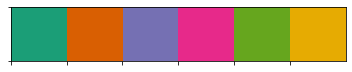

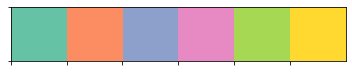

In [207]:
acl = metrics_df.age_cohort_low.unique()
pal = sns.color_palette('Dark2', len(acl))
pal2 = sns.color_palette('Set2', len(acl))
color_dict = {age:color for age, color in zip(acl, pal)}
color_dict2 = {age:color for age, color in zip(acl, pal2)}
sns.palplot(pal)
sns.palplot(pal2)

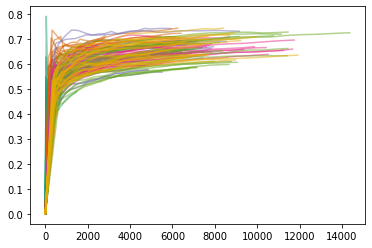

In [231]:
fig, ax = plt.subplots()
for age, color in color_dict.items():
    for idx, row in tqdm(metrics_df[metrics_df.age_cohort_low==age].iterrows(), leave=False):
        ax.plot(row.sequence_lengths[0],1 - (row.sequitur_compression_lengths[0] / row.sequence_lengths[0]), color = color, alpha = 0.5)
        #ax.plot(row.sequence_lengths[0], 1- (row.sequitur_compression_lengths_shuffled[0] / row.sequence_lengths[0]), color = 'black', alpha = 0.1)
        #ax.plot(row.sequence_lengths[0], 1- (row.sequitur_compression_lengths_markov[0]/ row.sequence_lengths[0]), color = 'grey', alpha = 0.1)
#ax.set_xscale('log')

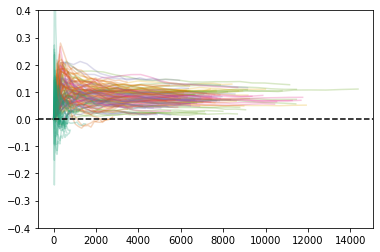

In [209]:
fig, ax = plt.subplots()
for age, color in list(color_dict.items())[::-1]:
    for idx, row in tqdm(metrics_df[metrics_df.age_cohort_low==age].iterrows(), leave=False):
        compressability_data = 1 - (row.sequitur_compression_lengths[0] / row.sequence_lengths[0])
        compressability_shuffled = 1- (row.sequitur_compression_lengths_shuffled[0] / row.sequence_lengths[0])
        compressability_markov = 1- (row.sequitur_compression_lengths_markov[0]/ row.sequence_lengths[0])
        ax.plot(row.sequence_lengths[0],compressability_data - compressability_markov, color = color, alpha = 0.25)
ax.set_ylim([-0.4, 0.4])
#ax.set_xscale('log')
ax.axhline(0, ls='dashed', color = 'k')
#ax.set_xlim([1, 10000])

In [210]:
np.unique(age_df_compression['seq_len_bin'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [211]:
n_bins = 25
bins = list(np.linspace(1, 18000, 25))

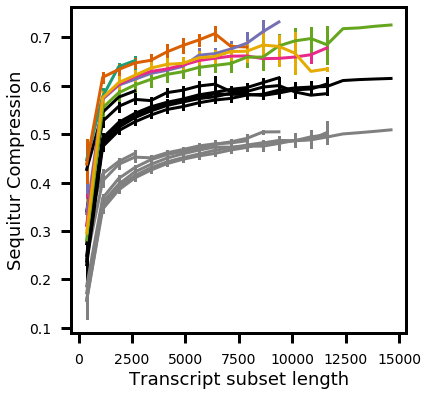

In [256]:
lw = 3 
fig, ax = plt.subplots(figsize=(6,6))

#for age, color in color_dict.items():
#    for idx, row in tqdm(metrics_df[metrics_df.age_cohort_low==age].iterrows(), leave=False):
#        ax.plot(row.sequence_lengths[0],1 - (row.sequitur_compression_lengths[0] / row.sequence_lengths[0]), color = color, alpha = 0.1)
#        ax.plot(row.sequence_lengths[0], 1- (row.sequitur_compression_lengths_shuffled[0] / row.sequence_lengths[0]), color = 'black', alpha = 0.1)
#        ax.plot(row.sequence_lengths[0], 1- (row.sequitur_compression_lengths_markov[0]/ row.sequence_lengths[0]), color = 'grey', alpha = 0.1)

for age, color in tqdm(color_dict.items()):
    age_df = metrics_df[metrics_df.age_cohort_low==age]
    
    age_df_compression = pd.DataFrame({
    "sequence_lengths": np.concatenate([i[0] for i in age_df.sequence_lengths.values]),
    "sequitur_compression_lengths_shuffled": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths_shuffled.values]),
    "sequitur_compression_lengths_markov": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths_markov.values]),
    "sequitur_compression_lengths": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths.values]),

    })
    age_df_compression['sequitur_compressability'] = 1- age_df_compression['sequitur_compression_lengths'] / age_df_compression['sequence_lengths']
    age_df_compression['sequitur_compressability_markov'] = 1- age_df_compression['sequitur_compression_lengths_markov'] / age_df_compression['sequence_lengths']
    age_df_compression['sequitur_compressability_shuffled'] = 1- age_df_compression['sequitur_compression_lengths_shuffled'] / age_df_compression['sequence_lengths']
    
    seq_lens = age_df_compression.sequence_lengths
    #bins = np.linspace(np.min(seq_lens), np.max(seq_lens), n_bins)
    age_df_compression['seq_len_bin'] = np.digitize(seq_lens, bins)
    age_df_compression['bin_val'] = [(bins[i-1] + bins[i])/2 for i in age_df_compression['seq_len_bin'].values]
    
    sns.lineplot(x="bin_val", y="sequitur_compressability",
                 ax= ax,
                 color = color_dict[age],
                 err_style="bars",
                 lw=lw,
                 err_kws= {"lw":lw},
             data=age_df_compression)
    
    sns.lineplot(x="bin_val", y="sequitur_compressability_markov",
                 ax= ax,
                 color = 'k',
                 err_style="bars",
                 lw=lw,
                  err_kws= {"lw":lw},

             #hue="region", style="event",
             data=age_df_compression)
    
    sns.lineplot(x="bin_val", y="sequitur_compressability_shuffled",
                 ax= ax,
                 color = 'grey',
                 err_style="bars",
                 lw=lw,
                  err_kws= {"lw":lw},

             #hue="region", style="event",
             data=age_df_compression)
    
    #break
ax.set_xlabel('Transcript subset length', fontsize=18)
ax.set_ylabel('Sequitur Compression', fontsize=18)

ax.tick_params(which="both",  labelsize=14, pad=10)
ax.tick_params(which="major", length=10, width=3)
ax.tick_params(which="minor", length=5, width=2)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")

ensure_dir(FIGURE_DIR/'sequitur')
save_fig(FIGURE_DIR/'sequitur'/'compression')

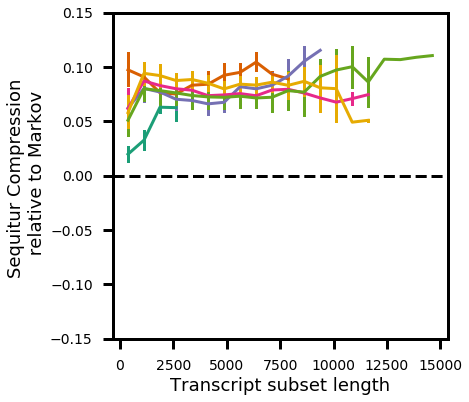

In [255]:
fig, ax = plt.subplots(figsize=(6,6))
for age, color in tqdm(color_dict.items()):
    age_df = metrics_df[metrics_df.age_cohort_low==age]
    
    age_df_compression = pd.DataFrame({
    "sequence_lengths": np.concatenate([i[0] for i in age_df.sequence_lengths.values]),
    "sequitur_compression_lengths_shuffled": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths_shuffled.values]),
    "sequitur_compression_lengths_markov": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths_markov.values]),
    "sequitur_compression_lengths": np.concatenate([i[0] for i in age_df.sequitur_compression_lengths.values]),

    })
    age_df_compression['sequitur_compressability'] = 1- age_df_compression['sequitur_compression_lengths'] / age_df_compression['sequence_lengths']
    age_df_compression['sequitur_compressability_markov'] = 1- age_df_compression['sequitur_compression_lengths_markov'] / age_df_compression['sequence_lengths']
    age_df_compression['sequitur_compressability_shuffled'] = 1- age_df_compression['sequitur_compression_lengths_shuffled'] / age_df_compression['sequence_lengths']

    
    age_df_compression['sequitur_compressability_rel_markov'] = age_df_compression['sequitur_compressability'] - age_df_compression['sequitur_compressability_markov']

    seq_lens = age_df_compression.sequence_lengths
    #bins = np.linspace(np.min(seq_lens), np.max(seq_lens), n_bins)
    age_df_compression['seq_len_bin'] = np.digitize(seq_lens, bins)
    age_df_compression['bin_val'] = [(bins[i-1] + bins[i])/2 for i in age_df_compression['seq_len_bin'].values]
    
    sns.lineplot(x="bin_val", y="sequitur_compressability_rel_markov",
                 ax= ax,
                 color = color_dict[age],
                 err_style="bars",
                 lw=lw,
              err_kws= {"lw":lw},
             data=age_df_compression)
    

    
#break
ax.axhline(0, color='k', ls='dashed', lw=3)
ax.set_ylim([-0.15, 0.15])

ax.set_xlabel('Transcript subset length', fontsize=18)
ax.set_ylabel('Sequitur Compression \n relative to Markov', fontsize=18)

ax.tick_params(which="both",  labelsize=14, pad=10)
ax.tick_params(which="major", length=10, width=3)
ax.tick_params(which="minor", length=5, width=2)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")

ensure_dir(FIGURE_DIR/'sequitur')
save_fig(FIGURE_DIR/'sequitur'/'compression_relative_markov')

In [239]:
metrics_df['transition_entropy_relative_to_random'] = metrics_df.mean_transition_entropy  - metrics_df.mean_transition_entropy_random

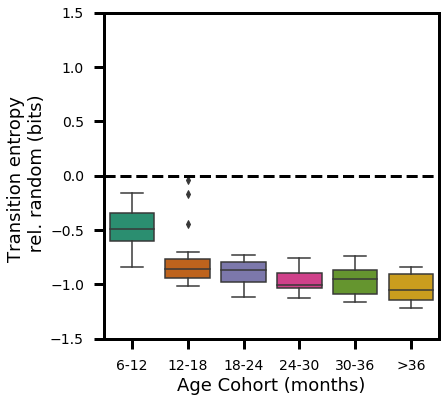

In [253]:
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x = "age_cohort_low", y="transition_entropy_relative_to_random", data = metrics_df, ax=ax, palette=pal)
ax.axhline(0, lw=3, color='k', ls='dashed')
ax.set_ylim([-1.5, 1.5])

ax.set_ylabel('Transition entropy \n rel. random (bits)', fontsize=18)
ax.set_xlabel('Age Cohort (months)', fontsize=18)

ax.tick_params(which="both",  labelsize=14, pad=10)
ax.tick_params(which="major", length=10, width=3)
ax.tick_params(which="minor", length=5, width=2)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("k")
ax.set_xticklabels(['6-12', '12-18', '18-24', '24-30', '30-36', '>36'])

ensure_dir(FIGURE_DIR/'sequitur')
save_fig(FIGURE_DIR/'sequitur'/'transition_entropy')

In [254]:
metrics_df.to_pickle(DATA_DIR / 'sequitur_metrics.pickle')